# Model Ref 3b - with modifications

In [ ]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [1]:
import keras
import pandas as pd
import tensorflow as tf

import numpy as np
# from keras.models import Sequential, Model
# from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import np_utils

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D, Input,AveragePooling2D, BatchNormalization, LeakyReLU

# from keras.applications import MobileNet
# from keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adadelta
from keras.regularizers import l2

from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import KFold

from collections import defaultdict
from PIL import Image

Using TensorFlow backend.


# Data Loading and Prep

In [2]:
def getSpeciesCode(x):
    part = x.split('_')
    if part[0] == 'ASETRI':
        return 0
    elif part[0] == 'EPTBOT':
        return 1
    elif part[0] == 'MYOEMA':
        return 2
    elif part[0] == 'PIPKUH':
        return 3
    elif part[0] == 'RHIMUS':
        return 4
    elif part[0] == 'RHYNAS':
        return 5
    elif part[0] == 'ROUAEG':
        return 6
    elif part[0] == 'TAPPER':
        return 7
    else:
        return 'Unknown'
    
def getSpecies(x):
    if x == 0:
        return 'ASETRI'
    elif x == 1:
        return 'EPTBOT'
    elif x == 2:
        return 'MYOEMA'
    elif x == 3:
        return 'PIPKUH'
    elif x == 4:
        return 'RHIMUS'
    elif x == 5:
        return 'RHYNAS'
    elif x == 6:
        return 'ROUAEG'
    elif x == 7:
        return 'TAPPER'
    else:
        return 'Unknown'

In [3]:
image_folder_path = 'data/SpectogramInitial'
file_paths = [f for f in os.listdir(image_folder_path)]
species = []
for file_name in file_paths:
    sp = file_name.split('_')
    species.append(sp[0])

df = pd.DataFrame(species, columns=['Species'])
df['Species'].value_counts()

RHIMUS    1799
TAPPER     429
PIPKUH     303
RHYNAS     271
EPTBOT     131
ROUAEG     121
MYOEMA     114
ASETRI      25
Name: Species, dtype: int64

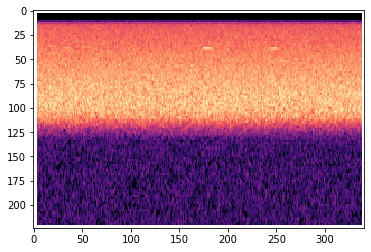

In [4]:
X_all = []
Y_all = []

image_folder_path = 'data/SpectogramInitial'
file_paths = [f for f in os.listdir(image_folder_path)]

for file_name in file_paths:
    spectrogram = Image.open(image_folder_path + '/' + file_name)
    spectrogram = spectrogram.convert('RGB')
    spectrogram = np.array(spectrogram)
    X_all.append(spectrogram)
    Y_all.append(getSpeciesCode(file_name))
    

plt.imshow(X_all[0])

In [5]:
X_all = np.array(X_all)
Y_all = np.array(Y_all)

print(X_all.shape)
print(Y_all.shape)

X_all = X_all.astype('float32')
X_all /= 255

Y_all = np_utils.to_categorical(Y_all, num_classes=8)

print(X_all[0])
print(Y_all)

(3193, 224, 341, 3)
(3193,)
[[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 ...

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]]
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [6]:
# train /test= 80/20% split
# Data is stratified
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.2, random_state = 123, stratify=Y_all)


# Model Building

In [7]:
def build_current_model():
    inp = Input(shape=(224, 341, 3))
    
    c1 = Convolution2D(filters=64,kernel_size=(7,7),strides=(2,2),padding='same')(inp)
    bt = BatchNormalization()(c1)
    bt = Activation('relu')(bt)
    mpool1 = MaxPooling2D(pool_size=(3,3),strides=2,padding='same')(bt)
    
    c2 = Convolution2D(filters=128,kernel_size=(7,7),strides=(2,2),padding='same')(mpool1)
    bt = BatchNormalization()(c2)
    bt = Activation('relu')(bt)
    mpool2 = AveragePooling2D(pool_size=(3,3),strides=(2,2),padding='same')(bt)
    
    c3 = Convolution2D(filters=256,kernel_size=(3,3),strides=(2,2),padding='same')(mpool2)
    bt = BatchNormalization()(c3)
    bt = Activation('relu')(bt)
    mpool3 = AveragePooling2D(pool_size=(3,3),strides=(2,2),padding='same')(bt)
    
    c4 = Convolution2D(filters=512,kernel_size=(3,3),strides=(2,2),padding='same')(mpool3)
    bt = BatchNormalization()(c4)
    bt = Activation('relu')(bt)
    mpool4 = AveragePooling2D(pool_size=(3,3),strides=(2,2),padding='same')(bt)
    
    f = Flatten()(mpool4)
    dp = Dropout(0.2)(f)
    x_dense = Dense(4096, activation='relu')(dp)
    
    dp2 = Dropout(0.2)(x_dense)
    x_dense2 = Dense(2048, activation='relu')(dp2)
    
    dp3 = Dropout(0.2)(x_dense2)
    x_dense3 = Dense(512, activation='relu')(dp3)
    
    x_out = Dense(8, name='output', activation='softmax', kernel_regularizer = l2(0.01))(x_dense3)
    model = Model(inputs=inp, outputs=x_out)
    model.compile(optimizer=Adadelta(lr = 0.002), 
                  loss='categorical_hinge', 
                  metrics = ['accuracy'])
    return model


In [8]:
model = build_current_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 341, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 112, 171, 64)      9472      
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 171, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 112, 171, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 86, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 43, 128)       401536    
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 43, 128)       512   

In [9]:
history = model.fit(X_train, Y_train, 
              epochs = 500, 
              validation_split=0.1, 
              verbose=1, 
              batch_size = 32)

history_info = history.history

Train on 2298 samples, validate on 256 samples
Epoch 1/500
2298/2298 [==============================] - 18s 8ms/sample - loss: 1.1918 - accuracy: 0.3033 - val_loss: 1.1629 - val_accuracy: 0.5703
Epoch 2/500
2298/2298 [==============================] - 13s 6ms/sample - loss: 1.1373 - accuracy: 0.5579 - val_loss: 1.1529 - val_accuracy: 0.5703
Epoch 3/500
2298/2298 [==============================] - 13s 6ms/sample - loss: 1.0917 - accuracy: 0.5627 - val_loss: 1.1237 - val_accuracy: 0.5703
Epoch 4/500
2298/2298 [==============================] - 13s 6ms/sample - loss: 1.0449 - accuracy: 0.5627 - val_loss: 1.0840 - val_accuracy: 0.5703
Epoch 5/500
2298/2298 [==============================] - 13s 6ms/sample - loss: 1.0084 - accuracy: 0.5635 - val_loss: 1.0511 - val_accuracy: 0.5703
Epoch 6/500
2298/2298 [==============================] - 13s 6ms/sample - loss: 0.9791 - accuracy: 0.5692 - val_loss: 1.0217 - val_accuracy: 0.5703
Epoch 7/500
2298/2298 [==============================] - 13s 6ms/

2298/2298 [==============================] - 14s 6ms/sample - loss: 0.6421 - accuracy: 0.7258 - val_loss: 0.5964 - val_accuracy: 0.7578
Epoch 56/500
2298/2298 [==============================] - 14s 6ms/sample - loss: 0.6353 - accuracy: 0.7354 - val_loss: 0.6018 - val_accuracy: 0.7578
Epoch 57/500
2298/2298 [==============================] - 14s 6ms/sample - loss: 0.6340 - accuracy: 0.7293 - val_loss: 0.5905 - val_accuracy: 0.7656
Epoch 58/500
2298/2298 [==============================] - 14s 6ms/sample - loss: 0.6270 - accuracy: 0.7376 - val_loss: 0.5862 - val_accuracy: 0.7617
Epoch 59/500
2298/2298 [==============================] - 14s 6ms/sample - loss: 0.6311 - accuracy: 0.7302 - val_loss: 0.5861 - val_accuracy: 0.7695
Epoch 60/500
2298/2298 [==============================] - 14s 6ms/sample - loss: 0.6187 - accuracy: 0.7411 - val_loss: 0.5814 - val_accuracy: 0.7656
Epoch 61/500
2298/2298 [==============================] - 13s 6ms/sample - loss: 0.6193 - accuracy: 0.7415 - val_loss: 

2298/2298 [==============================] - 14s 6ms/sample - loss: 0.4730 - accuracy: 0.8303 - val_loss: 0.4640 - val_accuracy: 0.8164
Epoch 111/500
2298/2298 [==============================] - 14s 6ms/sample - loss: 0.4673 - accuracy: 0.8377 - val_loss: 0.4454 - val_accuracy: 0.8359
Epoch 112/500
2298/2298 [==============================] - 14s 6ms/sample - loss: 0.4641 - accuracy: 0.8386 - val_loss: 0.4449 - val_accuracy: 0.8438
Epoch 113/500
2298/2298 [==============================] - 14s 6ms/sample - loss: 0.4644 - accuracy: 0.8407 - val_loss: 0.4489 - val_accuracy: 0.8359
Epoch 114/500
2298/2298 [==============================] - 14s 6ms/sample - loss: 0.4606 - accuracy: 0.8377 - val_loss: 0.4359 - val_accuracy: 0.8438
Epoch 115/500
2298/2298 [==============================] - 14s 6ms/sample - loss: 0.4578 - accuracy: 0.8394 - val_loss: 0.4421 - val_accuracy: 0.8516
Epoch 116/500
2298/2298 [==============================] - 14s 6ms/sample - loss: 0.4508 - accuracy: 0.8473 - val_

Epoch 165/500
2298/2298 [==============================] - 14s 6ms/sample - loss: 0.3659 - accuracy: 0.8873 - val_loss: 0.3657 - val_accuracy: 0.8984
Epoch 166/500
2298/2298 [==============================] - 14s 6ms/sample - loss: 0.3610 - accuracy: 0.8925 - val_loss: 0.3536 - val_accuracy: 0.8906
Epoch 167/500
2298/2298 [==============================] - 14s 6ms/sample - loss: 0.3562 - accuracy: 0.8943 - val_loss: 0.3579 - val_accuracy: 0.8867
Epoch 168/500
2298/2298 [==============================] - 15s 7ms/sample - loss: 0.3598 - accuracy: 0.8938 - val_loss: 0.3538 - val_accuracy: 0.8906
Epoch 169/500
2298/2298 [==============================] - 14s 6ms/sample - loss: 0.3485 - accuracy: 0.9003 - val_loss: 0.3629 - val_accuracy: 0.8906
Epoch 170/500
2298/2298 [==============================] - 16s 7ms/sample - loss: 0.3507 - accuracy: 0.8973 - val_loss: 0.3553 - val_accuracy: 0.8945
Epoch 171/500
2298/2298 [==============================] - 14s 6ms/sample - loss: 0.3507 - accuracy:

2298/2298 [==============================] - 15s 6ms/sample - loss: 0.2850 - accuracy: 0.9234 - val_loss: 0.3014 - val_accuracy: 0.9102
Epoch 220/500
2298/2298 [==============================] - 14s 6ms/sample - loss: 0.2915 - accuracy: 0.9252 - val_loss: 0.2966 - val_accuracy: 0.9141
Epoch 221/500
2298/2298 [==============================] - 14s 6ms/sample - loss: 0.2801 - accuracy: 0.9308 - val_loss: 0.3034 - val_accuracy: 0.9023
Epoch 222/500
2298/2298 [==============================] - 15s 6ms/sample - loss: 0.2844 - accuracy: 0.9252 - val_loss: 0.3084 - val_accuracy: 0.9023
Epoch 223/500
2298/2298 [==============================] - 16s 7ms/sample - loss: 0.2774 - accuracy: 0.9308 - val_loss: 0.3028 - val_accuracy: 0.9023
Epoch 224/500
2298/2298 [==============================] - 15s 7ms/sample - loss: 0.2775 - accuracy: 0.9317 - val_loss: 0.3068 - val_accuracy: 0.9062
Epoch 225/500
2298/2298 [==============================] - 16s 7ms/sample - loss: 0.2798 - accuracy: 0.9312 - val_

Epoch 274/500
2298/2298 [==============================] - 15s 7ms/sample - loss: 0.2302 - accuracy: 0.9552 - val_loss: 0.2731 - val_accuracy: 0.9258
Epoch 275/500
2298/2298 [==============================] - 14s 6ms/sample - loss: 0.2311 - accuracy: 0.9530 - val_loss: 0.2700 - val_accuracy: 0.9180
Epoch 276/500
2298/2298 [==============================] - 14s 6ms/sample - loss: 0.2333 - accuracy: 0.9487 - val_loss: 0.2739 - val_accuracy: 0.9180
Epoch 277/500
2298/2298 [==============================] - 14s 6ms/sample - loss: 0.2341 - accuracy: 0.9526 - val_loss: 0.2735 - val_accuracy: 0.9180
Epoch 278/500
2298/2298 [==============================] - 16s 7ms/sample - loss: 0.2311 - accuracy: 0.9543 - val_loss: 0.2628 - val_accuracy: 0.9258
Epoch 279/500
2298/2298 [==============================] - 15s 7ms/sample - loss: 0.2269 - accuracy: 0.9543 - val_loss: 0.2656 - val_accuracy: 0.9141
Epoch 280/500
2298/2298 [==============================] - 15s 6ms/sample - loss: 0.2335 - accuracy:

2298/2298 [==============================] - 14s 6ms/sample - loss: 0.1983 - accuracy: 0.9634 - val_loss: 0.2423 - val_accuracy: 0.9297
Epoch 329/500
2298/2298 [==============================] - 15s 6ms/sample - loss: 0.1973 - accuracy: 0.9634 - val_loss: 0.2416 - val_accuracy: 0.9258
Epoch 330/500
2298/2298 [==============================] - 14s 6ms/sample - loss: 0.1940 - accuracy: 0.9669 - val_loss: 0.2431 - val_accuracy: 0.9453
Epoch 331/500
2298/2298 [==============================] - 15s 7ms/sample - loss: 0.1935 - accuracy: 0.9669 - val_loss: 0.2451 - val_accuracy: 0.9336
Epoch 332/500
2298/2298 [==============================] - 15s 6ms/sample - loss: 0.1953 - accuracy: 0.9621 - val_loss: 0.2384 - val_accuracy: 0.9414
Epoch 333/500
2298/2298 [==============================] - 14s 6ms/sample - loss: 0.1884 - accuracy: 0.9695 - val_loss: 0.2358 - val_accuracy: 0.9336
Epoch 334/500
2298/2298 [==============================] - 14s 6ms/sample - loss: 0.1881 - accuracy: 0.9674 - val_

2298/2298 [==============================] - 13s 6ms/sample - loss: 0.1708 - accuracy: 0.9730 - val_loss: 0.2318 - val_accuracy: 0.9375
Epoch 383/500
2298/2298 [==============================] - 13s 6ms/sample - loss: 0.1733 - accuracy: 0.9721 - val_loss: 0.2219 - val_accuracy: 0.9414
Epoch 384/500
2298/2298 [==============================] - 13s 6ms/sample - loss: 0.1643 - accuracy: 0.9774 - val_loss: 0.2248 - val_accuracy: 0.9414
Epoch 385/500
2298/2298 [==============================] - 13s 6ms/sample - loss: 0.1725 - accuracy: 0.9735 - val_loss: 0.2350 - val_accuracy: 0.9375
Epoch 386/500
2298/2298 [==============================] - 13s 6ms/sample - loss: 0.1714 - accuracy: 0.9730 - val_loss: 0.2261 - val_accuracy: 0.9453
Epoch 387/500
2298/2298 [==============================] - 13s 6ms/sample - loss: 0.1710 - accuracy: 0.9717 - val_loss: 0.2287 - val_accuracy: 0.9453
Epoch 388/500
2298/2298 [==============================] - 13s 6ms/sample - loss: 0.1717 - accuracy: 0.9708 - val_

2298/2298 [==============================] - 13s 6ms/sample - loss: 0.1499 - accuracy: 0.9804 - val_loss: 0.2124 - val_accuracy: 0.9414
Epoch 437/500
2298/2298 [==============================] - 13s 6ms/sample - loss: 0.1499 - accuracy: 0.9787 - val_loss: 0.2162 - val_accuracy: 0.9453
Epoch 438/500
2298/2298 [==============================] - 13s 6ms/sample - loss: 0.1466 - accuracy: 0.9813 - val_loss: 0.2139 - val_accuracy: 0.9492
Epoch 439/500
2298/2298 [==============================] - 13s 6ms/sample - loss: 0.1465 - accuracy: 0.9822 - val_loss: 0.2247 - val_accuracy: 0.9375
Epoch 440/500
2298/2298 [==============================] - 13s 6ms/sample - loss: 0.1556 - accuracy: 0.9756 - val_loss: 0.2177 - val_accuracy: 0.9375
Epoch 441/500
2298/2298 [==============================] - 13s 6ms/sample - loss: 0.1502 - accuracy: 0.9791 - val_loss: 0.2176 - val_accuracy: 0.9414
Epoch 442/500
2298/2298 [==============================] - 13s 6ms/sample - loss: 0.1514 - accuracy: 0.9813 - val_

Epoch 491/500
2298/2298 [==============================] - 13s 6ms/sample - loss: 0.1355 - accuracy: 0.9830 - val_loss: 0.2173 - val_accuracy: 0.9414
Epoch 492/500
2298/2298 [==============================] - 13s 6ms/sample - loss: 0.1347 - accuracy: 0.9843 - val_loss: 0.2036 - val_accuracy: 0.9492
Epoch 493/500
2298/2298 [==============================] - 13s 6ms/sample - loss: 0.1348 - accuracy: 0.9839 - val_loss: 0.2143 - val_accuracy: 0.9453
Epoch 494/500
2298/2298 [==============================] - 13s 6ms/sample - loss: 0.1351 - accuracy: 0.9856 - val_loss: 0.2066 - val_accuracy: 0.9492
Epoch 495/500
2298/2298 [==============================] - 13s 6ms/sample - loss: 0.1366 - accuracy: 0.9852 - val_loss: 0.2118 - val_accuracy: 0.9414
Epoch 496/500
2298/2298 [==============================] - 13s 6ms/sample - loss: 0.1348 - accuracy: 0.9848 - val_loss: 0.2153 - val_accuracy: 0.9375
Epoch 497/500
2298/2298 [==============================] - 13s 6ms/sample - loss: 0.1384 - accuracy:

# Evaluation

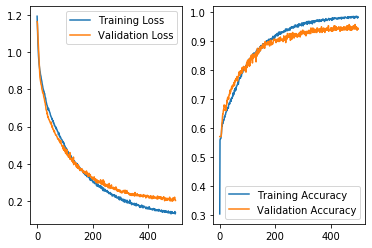

In [10]:
## Loss and accuracy history
_, axs = plt.subplots(ncols=2)
df_history_info = pd.DataFrame(history_info) 


sns.lineplot(data=df_history_info['loss'],ax=axs[0], label='Training Loss', legend='brief')
sns.lineplot(data=df_history_info['val_loss'],ax=axs[0], label='Validation Loss', legend='brief')

sns.lineplot(data=df_history_info['accuracy'],ax=axs[1], label='Training Accuracy', legend='brief')
sns.lineplot(data=df_history_info['val_accuracy'],ax=axs[1], label='Validation Accuracy', legend='brief')

In [11]:
def generate_actual_predicted(Y_pred, X_test, Y_test): 
    predicted = list()
    for i in range(len(Y_pred)):
        predicted.append(np.argmax(Y_pred[i]))
        
    actual = list()
    for i in range(len(Y_test)):
        actual.append(np.argmax(Y_test[i]))
        
    return actual, predicted

[[  0   0   0   1   3   0   1   0]
 [  0  26   0   0   0   0   0   0]
 [  0   1  20   1   0   0   1   0]
 [  0   0   0  56   1   4   0   0]
 [  0   1   0   1 354   1   2   1]
 [  0   1   1   1   0  51   0   0]
 [  0   0   3   0   2   1  18   0]
 [  0   0   0   2   4   0   2  78]]


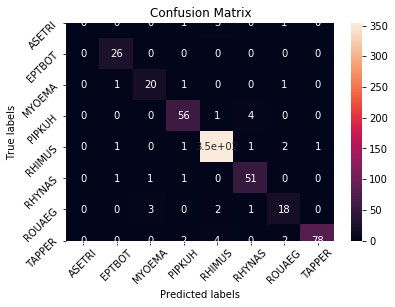

In [12]:
Y_pred = model.predict(X_test)
actual, predicted = generate_actual_predicted(Y_pred, X_test, Y_test)

##Confusion Matrix
from sklearn.metrics import confusion_matrix
actual_labeled = list()
predict_labeled = list()
for x,y in zip(actual,predicted):
    actual_labeled.append(getSpecies(x))
    predict_labeled.append(getSpecies(y))

labels = ['ASETRI','EPTBOT','MYOEMA','PIPKUH','RHIMUS','RHYNAS', 'ROUAEG', 'TAPPER']
cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels, rotation = 45); ax.yaxis.set_ticklabels(labels,rotation=45);

In [13]:
## Test accuracy
from sklearn.metrics import accuracy_score
print('accuracy', accuracy_score(actual, predicted))


accuracy 0.9436619718309859


In [14]:
## Precision, Recall, F1, Support
from sklearn.metrics import classification_report
print(classification_report(actual_labeled, predict_labeled,labels=labels))

              precision    recall  f1-score   support

      ASETRI       0.00      0.00      0.00         5
      EPTBOT       0.90      1.00      0.95        26
      MYOEMA       0.83      0.87      0.85        23
      PIPKUH       0.90      0.92      0.91        61
      RHIMUS       0.97      0.98      0.98       360
      RHYNAS       0.89      0.94      0.92        54
      ROUAEG       0.75      0.75      0.75        24
      TAPPER       0.99      0.91      0.95        86

    accuracy                           0.94       639
   macro avg       0.78      0.80      0.79       639
weighted avg       0.94      0.94      0.94       639



C:\Users\Tasli\Anaconda3\envs\keras-gpu\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
